In [2]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import matplotlib.patches as patches
from scipy.signal import stft, cwt
from scipy import signal
from scipy.fft import fft, fftfreq
import ssqueezepy

In [5]:
title = "Fugue in G minor"

file_name = {
    "piano": "バッハ 小フーガト短調 - J.S.Bach Fugue In G Minor BWV578.mp3",  # https://www.youtube.com/watch?v=l1fei3cXNzI
    "organ": "Bach - Fugue in G minor BWV 578.mp3",  # https://www.youtube.com/watch?v=PhRa3REdozw
    "orchestra": "Bach-Stokowski 'Little Fugue' - Bernstein introduces the Maestro.mp3",  # https://www.youtube.com/watch?v=AaCHqJmG7HQ
    "piano_synthetic": "Bach_Fugue_in_G_Minor_BWV_578_Piano_solo.mp3",  # https://musescore.com/user/24069/scores/633296
    "organ_synthetic": "Fugue_in_G_Minor_BWV_578_Little_Fugue.mp3",  # https://musescore.com/classicman/scores/3826491
}

instrument_type_list = [
    "piano",
    "organ",
    "orchestra",
    "piano_synthetic",
    "organ_synthetic",
]

data = dict()
for instrument_type in instrument_type_list:
    data[instrument_type] = librosa.load(f"music_data/{file_name[instrument_type]}")[0]
sr = 22050

# adjust the beginning point
data["piano"] = data["piano"][round(5.4 * sr) :]
data["organ"] = data["organ"][round(9.2 * sr) :]
data["orchestra"] = data["orchestra"][round(129.2 * sr) : -round(48.5 * sr)]

for instrument_type in instrument_type_list:
    print(
        f"Instrument: {instrument_type}. Array length: {len(data[instrument_type])}. Duration: {round(len(data[instrument_type]) / sr)} seconds"
    )

Instrument: piano. Array length: 4601571. Duration: 209 seconds
Instrument: organ. Array length: 4074901. Duration: 185 seconds
Instrument: orchestra. Array length: 5152052. Duration: 234 seconds
Instrument: piano_synthetic. Array length: 4034304. Duration: 183 seconds
Instrument: organ_synthetic. Array length: 4919040. Duration: 223 seconds


# Waveform

The music starts with the note $G$ = 391.995 Hz, namely period $T=2.55$ ms.

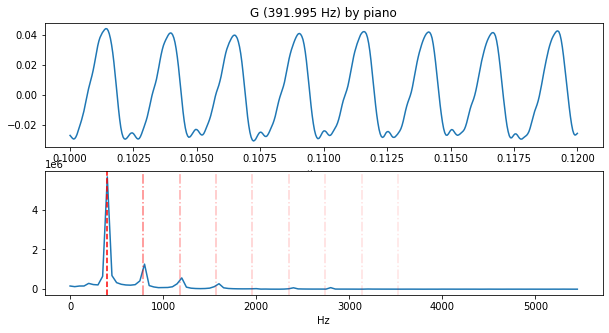

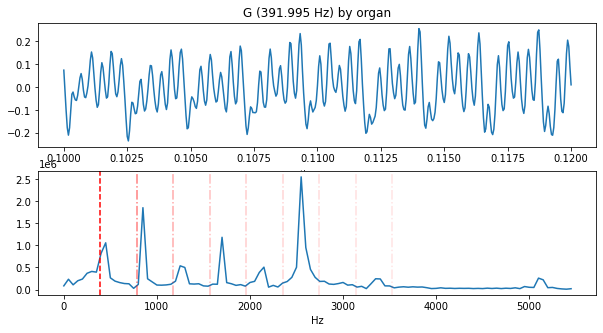

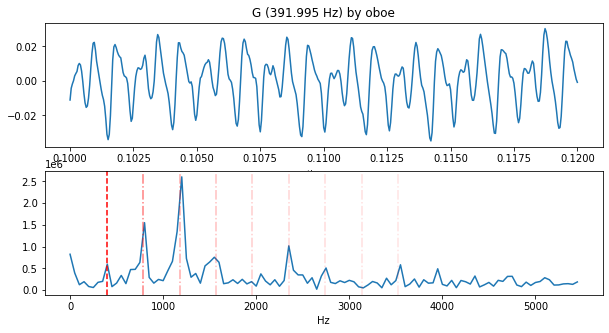

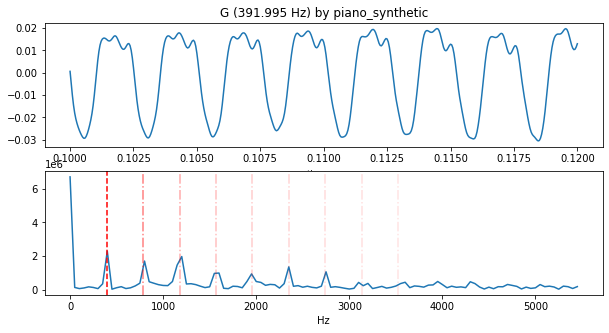

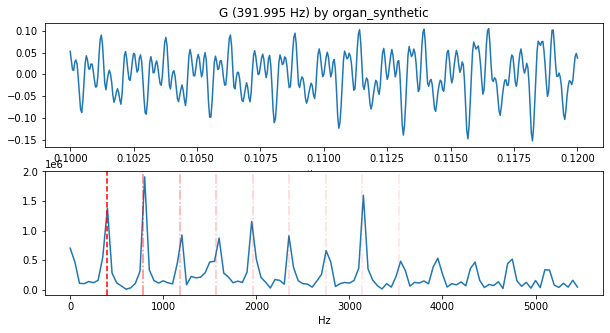

In [11]:
duration = 0.02
start = 0.1
s, e = round(sr * start), round(sr * (start + duration))
N = e - s
for instrument_type in instrument_type_list:
    fig, ax = plt.subplots(2, figsize=(10, 5))
    ax[0].plot(np.linspace(start, start + duration, N), data[instrument_type][s:e])
    ax[0].set_xlabel(r"time: $s$")
    ax[0].set_title(
        f"G (391.995 Hz) by {instrument_type if instrument_type != 'orchestra' else 'oboe'}"
    )
    normalized_tone = np.int16(
        (data[instrument_type][s:e] / data[instrument_type][s:e].max()) * 32767
    )
    yf = fft(normalized_tone)
    xf = fftfreq(N, 1 / sr)[: N // 4]
    ax[1].plot(xf, np.abs(yf[: N // 4]))
    ax[1].axvline(x=391.995, linestyle="--", color="r")
    for j in range(2, 10):
        ax[1].axvline(x=391.995 * j, linestyle="-.", color="r", alpha=1 / j)
    ax[1].set_xlabel("Hz")
    plt.savefig(
        f"final_project_figures/G_note_FFT_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
    )
    plt.show(fig)

- Seems like the organ is slightly out of tune.
- The organ has very strong harmonic overtones, and I believe that's why it sounds very grand.

# Short Time Fourier Transform

In [12]:
stft_result = dict()
for instrument_type in instrument_type_list:
    # stft_result[instrument_type] = np.abs(librosa.stft(data[instrument_type]))
    stft_result[instrument_type] = np.abs(
        stft(
            data[instrument_type], nperseg=2048, noverlap=512 * 3, return_onesided=True
        )[2]
    )

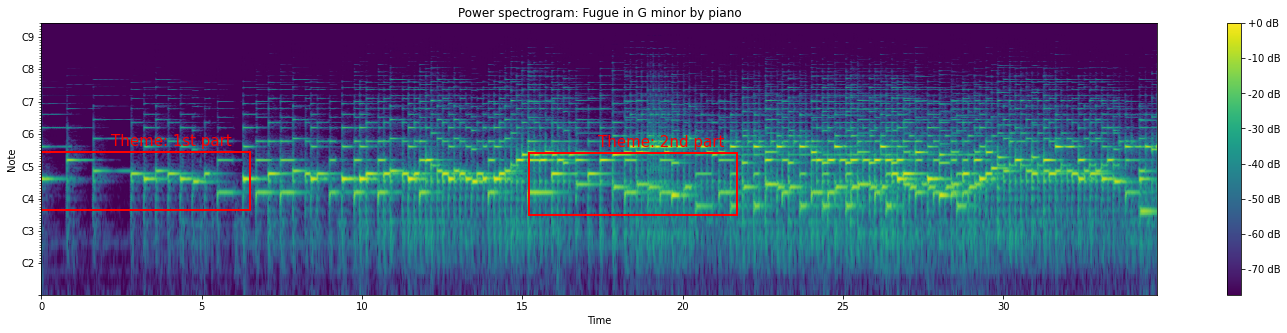

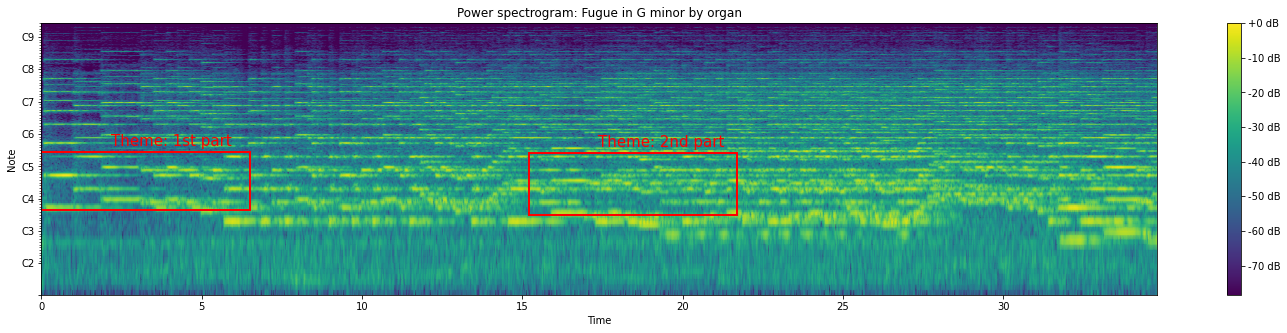

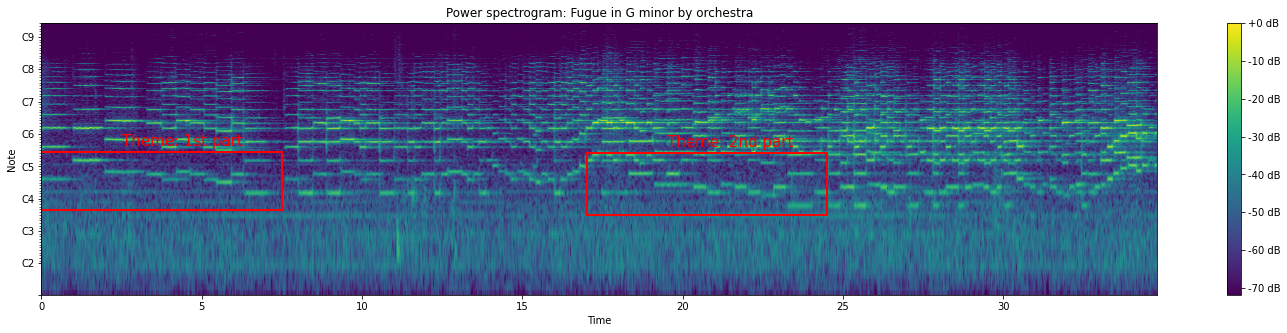

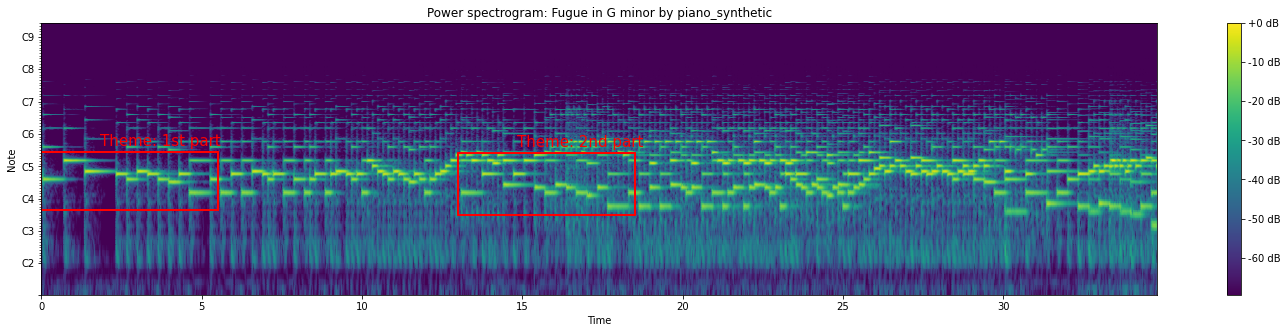

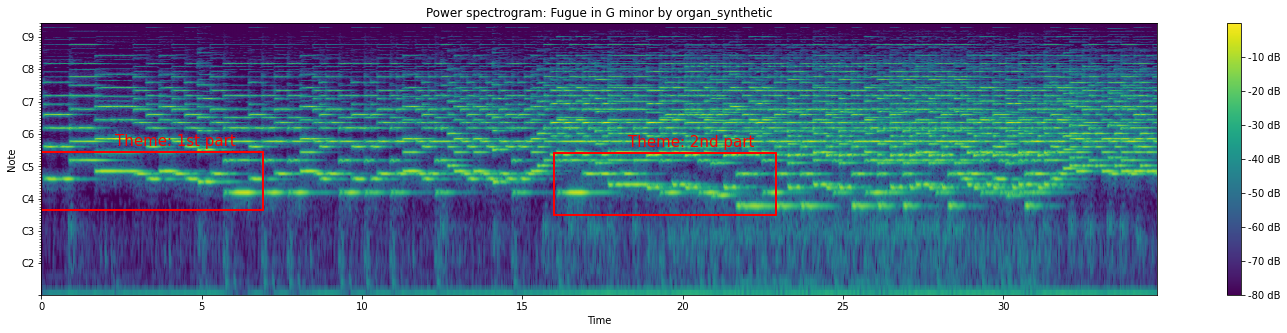

In [13]:
for instrument_type in instrument_type_list:
    fig, ax = plt.subplots(figsize=(25, 5))
    img = librosa.display.specshow(
        librosa.amplitude_to_db(stft_result[instrument_type][:, :1500], ref=np.max),
        # img = librosa.display.specshow(stft_result[instrument_type][:,:1500],
        y_axis="fft_note",
        x_axis="time",
        ax=ax,
        cmap="viridis",
        shading="gouraud",
    )
    ax.set_title(f"Power spectrogram: {title} by {instrument_type}")
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if instrument_type == "piano":
        x0, y0, dx, dy = 0, 200, 6.5, 500
        x1, y1 = 15.2, 180
    if instrument_type == "orchestra":
        x0, y0, dx, dy = 0, 200, 7.5, 500
        x1, y1 = 17, 180
    if instrument_type == "piano_synthetic":
        x0, y0, dx, dy = 0, 200, 5.5, 500
        x1, y1 = 13, 180
    if instrument_type == "organ_synthetic":
        x0, y0, dx, dy = 0, 200, 6.9, 500
        x1, y1 = 16, 180
    rect = patches.Rectangle(
        (x0, y0), dx, dy, linewidth=2, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    plt.text(
        x0 + 1 / 3 * dx, y0 + dy + 100, "Theme: 1st part", fontsize=15, color="red"
    )
    rect = patches.Rectangle(
        (x1, y1), dx, dy, linewidth=2, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    plt.text(
        x1 + 1 / 3 * dx, y1 + dy + 100, "Theme: 2nd part", fontsize=15, color="red"
    )
    plt.savefig(
        f"final_project_figures/stft_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
    )
    plt.show()

- Because a modern piano has dampers, the sound quickly fades away after the keys are released, while the organ does not have dampers, resulting in a long-lasting sound and creating a reverberation effect. When piano players perform music from the Baroque period, they often lightly press some pedals to extend the sound in order to simulate this effect.
- The orchestra version features the oboe playing the theme. Unlike the piano with its many strings or the organ with its many pipes, the oboe produces sound through the vibration of air within a single tube, and the pitch is changed by covering and uncovering finger holes. As a result, the previous note on the oboe quickly transitions to the next note, with a very short duration of maintaining the vibration pattern of the previous note. Therefore, on a frequency-time graph, we can observe that the previous note quickly disappears when the oboe plays the next note.

# Continuous Wavelet Transform

We use Morlet wavelet, which is well-suited for capturing oscillatory components in signals. It is a wavelet composed of a complex exponential (carrier) multiplied by a Gaussian window (envelope)

In [14]:
s = 0
N = round(2.8 * sr)
e = s + N
w = 5
freq = np.linspace(1, 2000, 100)
widths = w * sr / (2 * freq * np.pi)
cwtm = dict()
for instrument_type in instrument_type_list:
    cwtm[instrument_type] = cwt(data[instrument_type][s:e], signal.morlet2, widths, w=w)

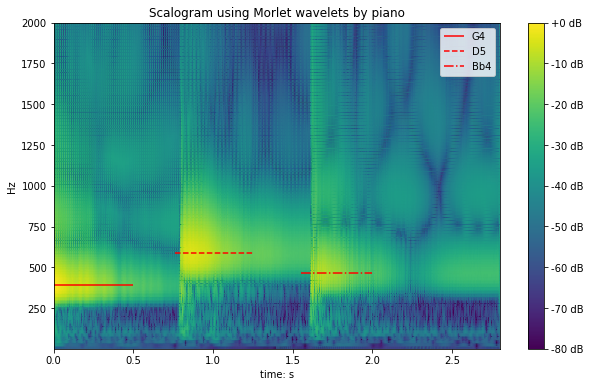

In [15]:
instrument_type = "piano"
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    np.arange(s, e) / sr,
    freq,
    librosa.amplitude_to_db(np.abs(cwtm[instrument_type]), ref=np.max),
    cmap="viridis",
    shading="gouraud",
)
plt.xlabel("time: s")
plt.ylabel("Hz")
# fig, ax = plt.subplots(figsize=(25, 5))
# librosa.display.specshow(librosa.amplitude_to_db(np.abs(cwtm[instrument_type]), ref=np.max),
# # img = librosa.display.specshow(stft_result[instrument_type][:,:1500],
#                          y_axis='fft_note', x_axis='time', y_coords=freq, x_coords=np.arange(s, e)/sr, ax=ax, cmap='viridis', sr=sr)
xmin1, xmax1 = 0, 0.5
xmin2, xmax2 = 0.76, 1.25
xmin3, xmax3 = 1.55, 2
plt.hlines(y=391.995, xmin=xmin1, xmax=xmax1, color="r", linestyle="-", label="G4")
plt.hlines(y=587.33, xmin=xmin2, xmax=xmax2, color="r", linestyle="--", label="D5")
plt.hlines(y=466.16, xmin=xmin3, xmax=xmax3, color="r", linestyle="-.", label="Bb4")
plt.legend()
plt.colorbar(format="%+2.0f dB")
plt.title(f"Scalogram using Morlet wavelets by {instrument_type}")
plt.savefig(
    f"final_project_figures/cwt_Morlet_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
)
plt.show()

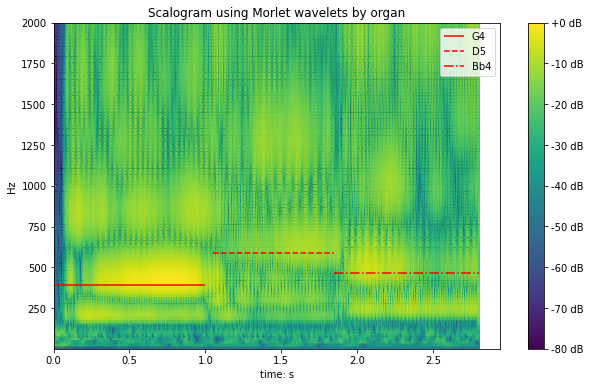

In [16]:
instrument_type = "organ"
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    np.arange(s, e) / sr,
    freq,
    librosa.amplitude_to_db(np.abs(cwtm[instrument_type]), ref=np.max),
    cmap="viridis",
    shading="gouraud",
)
xmin1, xmax1 = 0, 1
xmin2, xmax2 = 1.05, 1.85
xmin3, xmax3 = 1.85, 2.8
plt.hlines(y=391.995, xmin=xmin1, xmax=xmax1, color="r", linestyle="-", label="G4")
plt.hlines(y=587.33, xmin=xmin2, xmax=xmax2, color="r", linestyle="--", label="D5")
plt.hlines(y=466.16, xmin=xmin3, xmax=xmax3, color="r", linestyle="-.", label="Bb4")
plt.legend()
plt.xlabel("time: s")
plt.ylabel("Hz")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Scalogram using Morlet wavelets by {instrument_type}")
plt.savefig(
    f"final_project_figures/cwt_Morlet_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
)
plt.show()

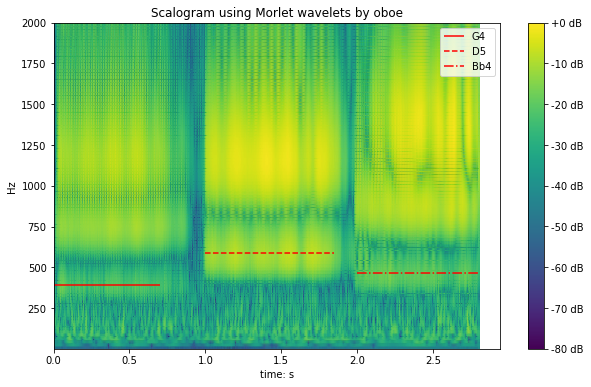

In [17]:
instrument_type = "orchestra"
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    np.arange(s, e) / sr,
    freq,
    librosa.amplitude_to_db(np.abs(cwtm[instrument_type]), ref=np.max),
    cmap="viridis",
    shading="gouraud",
)
xmin1, xmax1 = 0, 0.7
xmin2, xmax2 = 1.0, 1.85
xmin3, xmax3 = 2.0, 2.8
plt.hlines(y=391.995, xmin=xmin1, xmax=xmax1, color="r", linestyle="-", label="G4")
plt.hlines(y=587.33, xmin=xmin2, xmax=xmax2, color="r", linestyle="--", label="D5")
plt.hlines(y=466.16, xmin=xmin3, xmax=xmax3, color="r", linestyle="-.", label="Bb4")
plt.legend()
plt.xlabel("time: s")
plt.ylabel("Hz")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Scalogram using Morlet wavelets by oboe")
plt.savefig(
    f"final_project_figures/cwt_Morlet_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
)
plt.show()

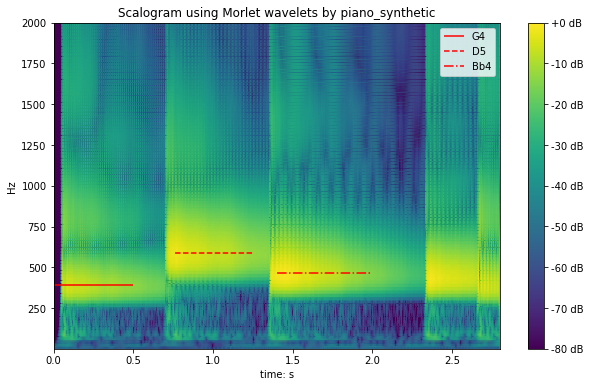

In [18]:
instrument_type = "piano_synthetic"
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    np.arange(s, e) / sr,
    freq,
    librosa.amplitude_to_db(np.abs(cwtm[instrument_type]), ref=np.max),
    cmap="viridis",
    shading="gouraud",
)
xmin1, xmax1 = 0, 0.5
xmin2, xmax2 = 0.76, 1.25
xmin3, xmax3 = 1.4, 2
plt.hlines(y=391.995, xmin=xmin1, xmax=xmax1, color="r", linestyle="-", label="G4")
plt.hlines(y=587.33, xmin=xmin2, xmax=xmax2, color="r", linestyle="--", label="D5")
plt.hlines(y=466.16, xmin=xmin3, xmax=xmax3, color="r", linestyle="-.", label="Bb4")
plt.legend()
plt.xlabel("time: s")
plt.ylabel("Hz")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Scalogram using Morlet wavelets by {instrument_type}")
plt.savefig(
    f"final_project_figures/cwt_Morlet_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
)
plt.show()

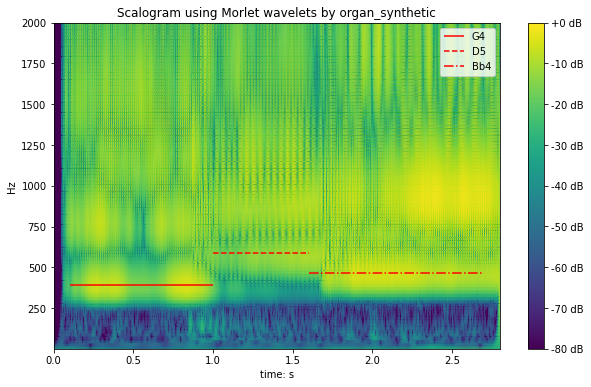

In [19]:
instrument_type = "organ_synthetic"
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    np.arange(s, e) / sr,
    freq,
    librosa.amplitude_to_db(np.abs(cwtm[instrument_type]), ref=np.max),
    cmap="viridis",
    shading="gouraud",
)
xmin1, xmax1 = 0.1, 1.0
xmin2, xmax2 = 1.0, 1.6
xmin3, xmax3 = 1.6, 2.7
plt.hlines(y=391.995, xmin=xmin1, xmax=xmax1, color="r", linestyle="-", label="G4")
plt.hlines(y=587.33, xmin=xmin2, xmax=xmax2, color="r", linestyle="--", label="D5")
plt.hlines(y=466.16, xmin=xmin3, xmax=xmax3, color="r", linestyle="-.", label="Bb4")
plt.legend()
plt.xlabel("time: s")
plt.ylabel("Hz")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Scalogram using Morlet wavelets by {instrument_type}")
plt.savefig(
    f"final_project_figures/cwt_Morlet_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
)
plt.show()

Although we have a general correspondence between scale and frequency:

Small scale $a$ $\Rightarrow$ Compressed wavelet $\Rightarrow$ Rapidly changing details $\Rightarrow$ High frequency $f$.

Long scale $a$ $\Rightarrow$ Stretched wavelet $\Rightarrow$ Slowly changing, coarse features $\Rightarrow$ Low frequency $f$.

While there is a general relationship between scale and frequency, no precise relationship exists. Namely, unlike the Fourier transform, there is not a naturally defined mapping between a wavelet at a given scale with a specified sampling period to a frequency in Hz. 

However, in a general sense, we can still look at the *pseudo-frequency* corresponding to a scale, by identifying the peak power in the Fourier transform of the wavelet as its center frequency and divides that value by the product of the scale and the sampling interval.

We found some patterns from the scalograms. 

- The sound of a piano is primarily concentrated on the fundamental frequency.

- The organ exhibits strong harmonic frequencies. 

- In the case of the oboe, the strength of the harmonics can even surpass that of the fundamental frequency. The reason may include the Reed vibration characteristics, air column resonance:,as well as interaction between reed and resonance cavity. However, despite the higher intensity of harmonics, the ear tends to perceive the note played on the oboe as the fundamental frequency rather than the harmonics. The brain perceives the pitch of a tone not only by its fundamental frequency, but also by the periodicity implied by the relationship between the higher harmonics; we may perceive the same pitch (perhaps with a different timbre) even if the fundamental frequency is missing from a tone. See https://en.wikipedia.org/wiki/Missing_fundamental


The characteristics of these spectra are consistent with our previous analysis of waveform graphs. However, when we previously examined waveform graphs and their Fourier transforms, we only captured very short segments (~0.02 seconds) containing a single note. Now, using wavelet transform, we can observe the spectral features of the instruments over longer time spans.

Our conclusion is that both spectrograms and scalograms can be used to distinguish the timbre of musical instruments,
but the differences are more pronounced in scalograms.

In particular, scalograms more clearly display the relative strength of the fundamental frequency and its harmonics

# Generalized Morese Wavelet

In [307]:
help(ssqueezepy._gmw.morsewave)
help(ssqueezepy.compute_gmw)
help(ssqueezepy.gmw)
help(ssqueezepy.cwt)

Help on function morsewave in module ssqueezepy._gmw:

morsewave(N, freqs, gamma=3, beta=60, K=1, norm='bandpass')
    Generalized Morse wavelets of Olhede and Walden (2002).
    
    # Arguments:
        N: int > 0
            Number of samples / wavelet length
    
        freqs: float / list / np.ndarray
            (peak) center frequencies at which to generate wavelets,
            in *radians* (i.e. `w` in `w = 2*pi*f`).
    
        gamma, beta: float, float
            GMW parameters; `(gamma, beta) = (3, 60)` yields optimal
            time-frequency localization, and a good default for natural signals.
              - smaller `beta`: greater time resolution, lower freq resolution.
              - `gamma`: structurally alters the wavelet; 2 and 1 provide
                superior time localization but poor joint localization.
            See refs [2], [3].
    
        K: int > 0
            Will compute first `K` orthogonal GMWs, characterized by
            orders 0 through `

## $\gamma = 3$, $\beta = 60$

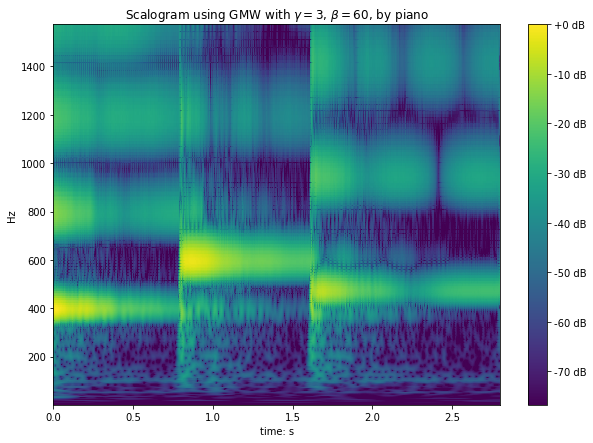

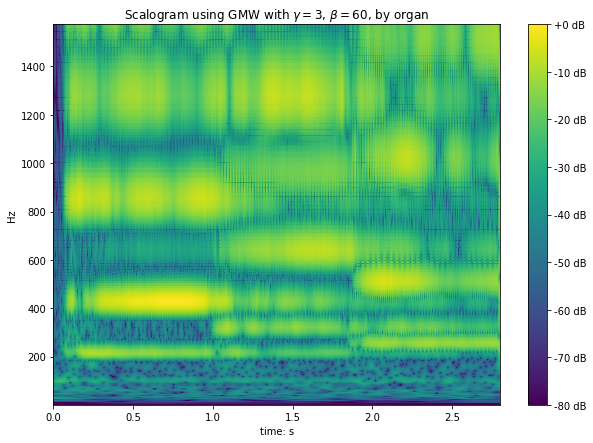

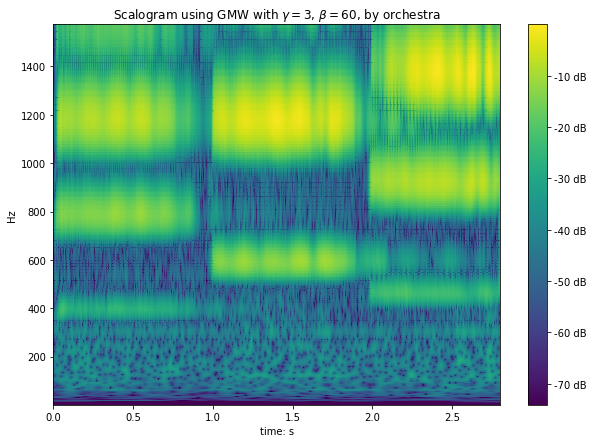

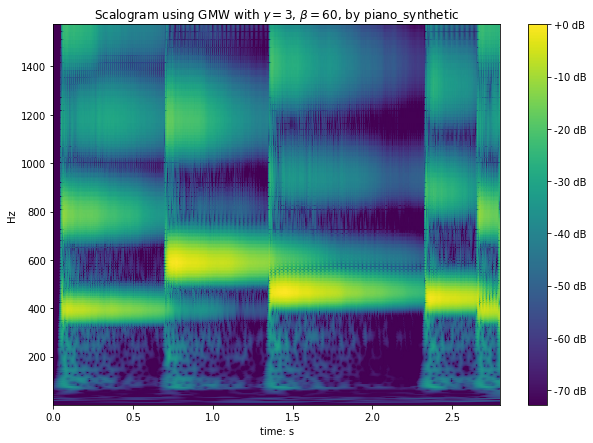

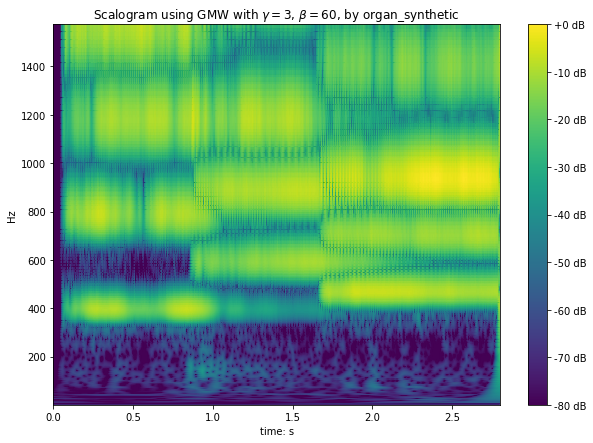

In [20]:
s = 0
N = round(2.8 * sr)
e = s + N
gamma = 3
beta = 60
for instrument_type in instrument_type_list:
    Wx, scale = ssqueezepy.cwt(
        data[instrument_type][s:e],
        wavelet=("gmw", {"gamma": gamma, "beta": beta, "centered_scale": True}),
    )
    freq = sr / (scale * 2 * np.pi)
    plt.figure(figsize=(10, 7))
    plt.pcolormesh(
        np.arange(s, e) / sr,
        freq[round(len(freq) * 1 / 3) :],
        librosa.amplitude_to_db(np.abs(Wx)[round(len(freq) * 1 / 3) :, :], ref=np.max),
        cmap="viridis",
        shading="gouraud",
    )
    plt.xlabel("time: s")
    plt.ylabel("Hz")
    plt.colorbar(format="%+2.0f dB")
    plt.title(
        rf"Scalogram using GMW with $\gamma={gamma}$, $\beta={beta}$, by {instrument_type}"
    )
    plt.savefig(
        f"final_project_figures/cwt_GMW_gamma={round(gamma)}_beta={round(beta)}_by_{instrument_type if instrument_type!='orchestra' else 'oboe'}.png"
    )
    plt.show()